In [1]:
import os
import pandas as pd
import json
import requests
import re
import datetime

import folium
from folium.plugins import BeautifyIcon

import matplotlib.pyplot as plt  # 2.2.2
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# PARAMETRES

In [2]:
dir_path = r'D:\DATA_ANALYSE\Meteo_France\QUOT' # YOUR_DIR_PATH
dep = ['08', '10', '51', '52', '54', '55', '57', '67', '68', '88'] # list of department numbers 
option = None # one of the options file for the Daily datasets : 'RR-T-Vent' or 'autres-parametres', None if you want all
option = 'RR-T-Vent' # one of the options file for the Daily datasets : 'RR-T-Vent' or 'autres-parametres', None if you want all

station_name = 'CHARLEVILLE' # extract by station name if you know it exactly, else None and enter the station_id
station_id = None # extract by station id if you know it, else None and enter the exact station_name

data_freq = 'DAY' # one of the options : '6MIN', 'HOUR', 'DAY', 'MONTH', 'DECA', 'DECAGRO'


# Téléchargement - Download

In [12]:
data_type = {'6MIN' : '6569ad61106d1679c93cdf77/',
             'HOUR' : '6569b4473bedf2e7abad3b72/',
             'DAY' : '6569b51ae64326786e4e8e1a/',
             'MONTH' : '6569b3d7d193b4daf2b43edc/',
             'DECA' : '6569b4a48a4161faec6b2779/',
             'DECAGRO' : '6569af36ba0c3d2f9d4bf98c/'}

In [13]:
# general link of the datasets
url = 'https://www.data.gouv.fr/api/2/datasets/' + data_type[data_freq]

In [14]:
response = requests.get(url)
response

<Response [200]>

In [15]:
# finding how many pages for all datasets
nb_pages = json.loads(response.text)['resources']['total']
nb_pages

626

In [16]:
url_dep = url + f'/resources/?page=1&page_size={nb_pages}&type=main'

In [17]:
response = requests.get(url_dep)
data = response.json()

In [18]:
# grab all the page to find the department datasets
compte = 0
for k in range(len(data['data'])):
    titre = data['data'][k]['title']
    m=re.search('departement_([0-9]{2,3})_', titre)
    if m is not None and m.group(1) in dep and (option is None or (option is not None and option in titre)):        
        url1 = data['data'][k]['url']
        format = data['data'][k]['format']
        resp = requests.get(url1)
        if resp.status_code == 200:
            with open(os.path.join(dir_path, titre + '.' + format), 'wb') as file:
                file.write(resp.content)  
                compte += 1
        else:
            print('problem with ', titre)
print(compte, ' file(s) downloaded')
            

60  file(s) downloaded


# Extraction données de la station

In [23]:
# list the files of the department(s)
liste_file = []
for file_path in os.listdir(dir_path):
    # check if current file_path is a file
    if os.path.isfile(os.path.join(dir_path, file_path)):
        # add filename to list
        liste_file.append(file_path)

data_files = []
for file_n in liste_file:
    m=re.search('departement_([0-9]{2,3})_', file_n)
    if m is not None and m.group(1) in dep and (option is None or (option is not None and option in file_n)): 
        data_files.append(file_n)

print(data_files)

['QUOT_departement_08_periode_1871-1949_RR-T-Vent.csv.gz', 'QUOT_departement_08_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departement_08_periode_2023-2024_RR-T-Vent.csv.gz', 'QUOT_departement_10_periode_1861-1949_RR-T-Vent.csv.gz', 'QUOT_departement_10_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departement_10_periode_2023-2024_RR-T-Vent.csv.gz', 'QUOT_departement_51_periode_1871-1949_RR-T-Vent.csv.gz', 'QUOT_departement_51_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departement_51_periode_2023-2024_RR-T-Vent.csv.gz', 'QUOT_departement_52_periode_1852-1949_RR-T-Vent.csv.gz', 'QUOT_departement_52_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departement_52_periode_2023-2024_RR-T-Vent.csv.gz', 'QUOT_departement_54_periode_1871-1949_RR-T-Vent.csv.gz', 'QUOT_departement_54_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departement_54_periode_2023-2024_RR-T-Vent.csv.gz', 'QUOT_departement_55_periode_1864-1949_RR-T-Vent.csv.gz', 'QUOT_departement_55_periode_1950-2022_RR-T-Vent.csv.gz', 'QUOT_departe

## OPTION 1 : dataset de toutes les stations (et de tous les départements téléchargés)

In [24]:
df_all = pd.DataFrame()
for file_name in data_files:
    df_0 = pd.read_csv(os.path.join(dir_path, file_name), sep = ';')    
    df_all = pd.concat([df_all, df_0], ignore_index = True)
df_all.head()

NUM_POSTE NOM_USUEL   LAT       LON  ALTI  AAAAMMJJ   RR  QRR  TN  QTN  \
0    8016001    AOUSTE  49.8  4.316667   204  18800601  0.0  1.0 NaN  NaN   
1    8016001    AOUSTE  49.8  4.316667   204  18800602  0.0  1.0 NaN  NaN   
2    8016001    AOUSTE  49.8  4.316667   204  18800603  0.0  1.0 NaN  NaN   
3    8016001    AOUSTE  49.8  4.316667   204  18800604  0.0  1.0 NaN  NaN   
4    8016001    AOUSTE  49.8  4.316667   204  18800605  0.0  1.0 NaN  NaN   

   ...  DXI2  QDXI2  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  
0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN  
1  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN  
2  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN  
3  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN  
4  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN  

[5 rows x 56 columns]

**<span style="color:red">df_all</span> is the dataset of all the stations**

### SAVE your dataset in a file

In [27]:
file_path = os.path.join(dir_path, 'my_region_Grand_Est.csv')
df_all.to_csv(file_path, compression='gzip' , sep = ';', index = False)

## OPTION 2 : dataset de la station uniquement

In [15]:
df_station = pd.DataFrame()
for file_name in data_files:
    df0 = pd.read_csv(os.path.join(dir_path, file_name), sep = ';')
    if station_id is not None:
        df0 = df0[df0['NUM_POSTE'] == station_id]
    else:
        df0 = df0[df0['NOM_USUEL'] == station_name]
    df_station = pd.concat([df_station, df0], ignore_index = True)
df_station.head()

NUM_POSTE  NOM_USUEL        LAT  LON  ALTI  AAAAMM    RR  QRR  NBRR  RR_ME  \
0   56057001  LE FAOUET  48.033333 -3.5   155  189201  26.0  9.0  31.0    NaN   
1   56057001  LE FAOUET  48.033333 -3.5   155  189202  55.0  9.0  29.0    NaN   
2   56057001  LE FAOUET  48.033333 -3.5   155  189203  17.0  9.0  31.0    NaN   
3   56057001  LE FAOUET  48.033333 -3.5   155  189204  34.0  9.0  30.0    NaN   
4   56057001  LE FAOUET  48.033333 -3.5   155  189205  28.0  9.0  31.0    NaN   

   ...  QNEIGETOTM   NEIGETOTAB  QNEIGETOTAB  NEIGETOTABDAT  NBJNEIGETOT1  \
0  ...         NaN          NaN          NaN            NaN           NaN   
1  ...         NaN          NaN          NaN            NaN           NaN   
2  ...         NaN          NaN          NaN            NaN           NaN   
3  ...         NaN          NaN          NaN            NaN           NaN   
4  ...         NaN          NaN          NaN            NaN           NaN   

   NBJNEIGETOT10  NBJNEIGETOT30  NBJGREL  NBJORAG  NBJBROU  
0            NaN            NaN      NaN      NaN      NaN  
1            NaN            NaN      NaN      NaN      NaN  
2            NaN            NaN      NaN      NaN      NaN  
3            NaN            NaN      NaN      NaN      NaN  
4            NaN            NaN      NaN      NaN      NaN  

[5 rows x 162 columns]

**<span style="color:red">df_station</span> is the dataset of your selected station, enjoy !**

### SAVE your dataset in a file

In [16]:
file_path = os.path.join(dir_path, 'my_station.csv')
df_station.to_csv(file_path, sep = ';', index = False)

# EXPLOITATION DONNEES

## fonctions

In [3]:
def transfo_an(x):
    return str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]


def select_feature(df, feat):
    df1 = df.copy()
    df1['AAAAMMJJ'] = df1['AAAAMMJJ'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6] + '-' + str(x)[6:])
    df1['AAAAMMJJ'] = pd.to_datetime(df1['AAAAMMJJ'])
    return df1[['AAAAMMJJ', feat]]
    

def select_feature2(df, feat):
    df1 = df.copy()
    df1['AAAAMMJJ'] = df1['AAAAMMJJ'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6] + '-' + str(x)[6:])
    df1['AAAAMMJJ'] = pd.to_datetime(df1['AAAAMMJJ'])
    return df1[['NUM_POSTE', 'NOM_USUEL', 'AAAAMMJJ', feat]]


def parse_date(df):
    # convert the date column into a datetime object
    df1 = df.copy()
    df1['DATE'] = pd.to_datetime(df1['DATE'])
    # extract the day, month, and year components
    df1['day'] = df1['DATE'].dt.day
    df1['month'] = df1['DATE'].dt.month
    df1['year'] = df1['DATE'].dt.year
    return df1


def to_num(df, feat):
    df1 = df.copy()
    df1[feat] = df1[feat].astype('str')
    df1[feat] = df1[feat].apply(lambda x : x.replace(',', '.')).astype('float')
    return df1


def df_tempe(df, param):
    df1 = select_feature(df, param)
    df1 = to_num(df1, param)
    return df1

def df_tempe2(df, param):
    df1 = select_feature2(df, param)
    df1 = to_num(df1, param)
    return df1

## Chargement fichier

In [4]:
file_path = os.path.join(dir_path, 'my_region_Grand_Est.csv')
df_all = pd.read_csv(file_path, sep=';', compression = 'gzip')

# Stations avec le plus de données (dans le temps)

In [6]:
df_stations_infos = df_all.groupby(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI']).agg(annee_debut=('AAAAMMJJ', 'min'),
                                                                            annee_fin = ('AAAAMMJJ', 'max')).reset_index()

In [7]:
df_stations_infos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NUM_POSTE    1367 non-null   int64  
 1   NOM_USUEL    1367 non-null   object 
 2   LAT          1367 non-null   float64
 3   LON          1367 non-null   float64
 4   ALTI         1367 non-null   int64  
 5   annee_debut  1367 non-null   int64  
 6   annee_fin    1367 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 74.9+ KB


In [8]:
df_stations_infos['annee_debut']= pd.to_datetime(df_stations_infos['annee_debut'].apply(lambda x : transfo_an(x)))
df_stations_infos['annee_fin']= pd.to_datetime(df_stations_infos['annee_fin'].apply(lambda x : transfo_an(x)))
df_stations_infos

NUM_POSTE      NOM_USUEL        LAT       LON  ALTI annee_debut  \
0       8001001    ACY-ROMANCE  49.500833  4.339167    99  2014-05-01   
1       8016001         AOUSTE  49.800000  4.316667   204  1880-06-01   
2       8024001         ASFELD  49.468333  4.118333    65  1891-03-01   
3       8025001        ATTIGNY  49.475000  4.575000    81  1960-07-01   
4       8025011  ATTIGNY BOURG  49.478333  4.576667    89  1891-01-01   
...         ...            ...        ...       ...   ...         ...   
1362   88530001       XERTIGNY  48.044000  6.397833   485  1969-07-01   
1363   88530002       XERTIGNY  48.045000  6.401667   496  1883-02-01   
1364   88531002       LONGEMER  48.068500  6.948500   745  1949-02-01   
1365   88531003        XONRUPT  48.051667  7.008333  1220  1969-10-01   
1366   88531004       LONGEMER  48.066667  6.966667   780  1883-03-01   

      annee_fin  
0    2019-12-31  
1    1914-05-31  
2    1914-05-31  
3    2007-09-30  
4    1940-04-30  
...         ...  
1362 2009-08-31  
1363 1913-12-31  
1364 2022-04-30  
1365 1997-12-31  
1366 1895-10-31  

[1367 rows x 7 columns]

## Carte des stations

In [9]:
layer = 'LIMITES_ADMINISTRATIVES_EXPRESS.LATEST'
#format1 = 'image/jpeg'
format1 = 'image/png'
style = 'normal'
CLEF = 'administratif'

tiles = f'https://wxs.ign.fr/{CLEF}/geoportail/wmts?service=WMTS&request=GetTile&version=1.0.0&tilematrixset=PM&layer={layer}&format={format1}&style={style}'
tiles += '&tilematrix={z}&tilecol={x}&tilerow={y}'

my_map = folium.Map(location=[48.8, 5.5], zoom_start = 8, tiles = None, width = 1000, height = 800)
folium.raster_layers.TileLayer(tiles=tiles, name ='Station Météo', attr='Geoportail').add_to(my_map)

In [10]:
group_active = folium.FeatureGroup(name='<span style="color: blue;">active ●</span>')
group_inactive = folium.FeatureGroup(name='<span style="color: red;">inactive ▲</span>')

for indice, row in df_stations_infos.iterrows():
    icon_circle = BeautifyIcon(
    icon='circle', 
    text_color='blue', 
    background_color='transparent',
    border_color='transparent',
    )
    
    icon_triangle = BeautifyIcon(
    icon='triangle-exclamation', 
    text_color='red', 
    background_color='transparent',
    border_color='transparent',)
    html = row['NOM_USUEL']
    
    

    if row['annee_fin'].year == 2024:
        ico= icon_circle
        gr = group_active
        html += '<br>active depuis ' + str(row['annee_debut'].year)
        ht = 60
        
        
    else:
        ico = icon_triangle
        gr = group_inactive
        html += '<br>ouverte en ' + str(row['annee_debut'].year) + '<br>fermée en ' + str(row['annee_fin'].year)
        ht = 70

    iframe = folium.IFrame(html,
                           width = 200,
                           height = ht)
    popup = folium.Popup(iframe,
                         max_width = 200)
    folium.Marker(
        location=[row['LAT'], row['LON']],        
        #popup=row['NOM_USUEL'],
        icon=ico,
        popup = popup
        #icon= folium.Icon(color='blue' if row['annee_fin'].year == 2024 else 'red', icon='glyphicon-book'),
        #radius = 5 if row['annee_fin'].year == 2024 else 2,
        #color = 'blue' if row['annee_fin'].year == 2024 else 'red'
        ).add_to(gr)
        


group_active.add_to(my_map)
group_inactive.add_to(my_map)
folium.LayerControl().add_to(my_map)
my_map

## Stations avec le plus de données pour un paramètre

In [11]:
param = 'TX'

In [12]:
df_param = df_all[~df_all[param].isna()]
df_param['AAAAMMJJ'] =  pd.to_datetime(df_param['AAAAMMJJ'].apply(lambda x: transfo_an(x)))

C:\Users\thepe\AppData\Local\Temp\ipykernel_9752\1961390657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param['AAAAMMJJ'] =  pd.to_datetime(df_param['AAAAMMJJ'].apply(lambda x: transfo_an(x)))


In [13]:
df_param_infos = df_param.groupby(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI']).agg(annee_debut=('AAAAMMJJ', 'min'),
                                                                                        annee_fin = ('AAAAMMJJ', 'max'),
                                                                                       nombre_valeurs =('AAAAMMJJ', lambda x:x.nunique())).reset_index()
df_param_infos = df_param_infos.sort_values('nombre_valeurs', ascending=False)
df_param_infos.head(20)

NUM_POSTE                NOM_USUEL        LAT       LON  ALTI  \
354   67482001   STRASBOURG - BOTANIQUE  48.581833  7.768833   139   
79    10323001                  ROMILLY  48.503333  3.749500    77   
318   67124001      STRASBOURG-ENTZHEIM  48.549500  7.640333   150   
213   54526001              NANCY-ESSEY  48.687833  6.221500   212   
267   57039001            METZ-FRESCATY  49.069500  6.125333   192   
97    51183001             REIMS-COURCY  49.306167  4.050667    91   
236   55179001  ERNEVILLE AUX BOIS_SAPC  48.749500  5.403833   313   
274   57168001          PHALSBOURG_SAPC  48.766667  7.305833   377   
454   88321001              NEUFCHATEAU  48.350500  5.692167   284   
337   67340001               ZINSWILLER  48.923333  7.593333   201   
413   68297001            BALE-MULHOUSE  47.614333  7.510000   263   
452   88304005                MIRECOURT  48.312167  6.135167   265   
166   52269001                  LANGRES  47.843667  5.337500   466   
53    10057001           BOUY-SUR-ORVIN  48.439833  3.504833   102   
61    10130001                   DOSNON  48.609167  4.224667   115   
128   51545001                SOMMESOUS  48.734167  4.207500   167   
175   52448001                ST-DIZIER  48.631333  4.903667   139   
394   68224006                 MULHOUSE  47.750000  7.288833   245   
103   51237001             ESTERNAY-MAN  48.737833  3.575667   175   
392   68205001         COLMAR-MEYENHEIM  47.928667  7.407667   207   

    annee_debut  annee_fin  nombre_valeurs  
354  1922-01-01 2024-01-14           37259  
79   1921-03-23 2024-01-14           35902  
318  1924-01-01 2024-01-14           35345  
213  1927-09-13 2024-01-14           33361  
267  1940-11-01 2024-01-14           29872  
97   1929-01-01 2014-04-24           28991  
236  1934-05-01 2024-01-14           28966  
274  1946-01-01 2024-01-14           28498  
454  1883-03-01 2012-12-31           28474  
337  1912-01-01 1994-12-31           28340  
413  1947-01-01 2024-01-14           28138  
452  1939-01-01 2017-09-30           27820  
166  1949-01-01 2024-01-14           27407  
53   1949-04-01 2024-01-14           27157  
61   1949-11-01 2024-01-14           27013  
128  1951-01-01 2024-01-14           26677  
175  1921-01-01 2024-01-14           26128  
394  1955-01-01 2024-01-14           25188  
103  1954-01-01 2020-12-31           24472  
392  1957-04-01 2024-01-14           24395

## stations toujours actives

In [14]:
today = datetime.date.today()
current_year = today.year

df_param_infos_active = df_param_infos[df_param_infos['annee_fin'].apply(lambda x : x.year) == current_year]
df_param_infos_active.head(20)

NUM_POSTE                NOM_USUEL        LAT       LON  ALTI  \
354   67482001   STRASBOURG - BOTANIQUE  48.581833  7.768833   139   
79    10323001                  ROMILLY  48.503333  3.749500    77   
318   67124001      STRASBOURG-ENTZHEIM  48.549500  7.640333   150   
213   54526001              NANCY-ESSEY  48.687833  6.221500   212   
267   57039001            METZ-FRESCATY  49.069500  6.125333   192   
236   55179001  ERNEVILLE AUX BOIS_SAPC  48.749500  5.403833   313   
274   57168001          PHALSBOURG_SAPC  48.766667  7.305833   377   
413   68297001            BALE-MULHOUSE  47.614333  7.510000   263   
166   52269001                  LANGRES  47.843667  5.337500   466   
53    10057001           BOUY-SUR-ORVIN  48.439833  3.504833   102   
61    10130001                   DOSNON  48.609167  4.224667   115   
128   51545001                SOMMESOUS  48.734167  4.207500   167   
175   52448001                ST-DIZIER  48.631333  4.903667   139   
394   68224006                 MULHOUSE  47.750000  7.288833   245   
392   68205001         COLMAR-MEYENHEIM  47.928667  7.407667   207   
171   52332001             VAL-DE-MEUSE  48.021500  5.586833   380   
16     8239001                JUNIVILLE  49.397333  4.371667    90   
415   68307001  SEWEN - LAC ALFELD_SAPC  47.815500  6.873833   620   
182   54040001              BADONVILLER  48.498000  6.896167   336   
380   68102001           GEISHOUSE_SAPC  47.875333  7.056833   618   

    annee_debut  annee_fin  nombre_valeurs  
354  1922-01-01 2024-01-14           37259  
79   1921-03-23 2024-01-14           35902  
318  1924-01-01 2024-01-14           35345  
213  1927-09-13 2024-01-14           33361  
267  1940-11-01 2024-01-14           29872  
236  1934-05-01 2024-01-14           28966  
274  1946-01-01 2024-01-14           28498  
413  1947-01-01 2024-01-14           28138  
166  1949-01-01 2024-01-14           27407  
53   1949-04-01 2024-01-14           27157  
61   1949-11-01 2024-01-14           27013  
128  1951-01-01 2024-01-14           26677  
175  1921-01-01 2024-01-14           26128  
394  1955-01-01 2024-01-14           25188  
392  1957-04-01 2024-01-14           24395  
171  1959-01-01 2024-01-14           23674  
16   1959-01-01 2024-01-14           23198  
415  1959-01-01 2024-01-14           22836  
182  1959-01-01 2024-01-14           22370  
380  1965-01-01 2024-01-14           21563

## Choix des stations

In [136]:
stations_utiles = [67482001, 10323001, 54526001, 57039001, 55179001, 68297001, 52269001, 51545001, 8239001]
param = 'TX'

In [137]:
df_stat = df_all[df_all['NUM_POSTE'].isin(stations_utiles) & (~df_all[param].isna())]

In [138]:
df_temp_maxi = df_tempe2(df_stat, param)

df_temp_maxi

NUM_POSTE      NOM_USUEL   AAAAMMJJ   TX
740045      8239001      JUNIVILLE 1959-01-01  8.0
740046      8239001      JUNIVILLE 1959-01-02  7.0
740047      8239001      JUNIVILLE 1959-01-03  6.5
740048      8239001      JUNIVILLE 1959-01-04  4.0
740049      8239001      JUNIVILLE 1959-01-05  3.0
...             ...            ...        ...  ...
11616127   68297001  BALE-MULHOUSE 2024-01-10 -1.7
11616128   68297001  BALE-MULHOUSE 2024-01-11 -1.6
11616129   68297001  BALE-MULHOUSE 2024-01-12 -2.2
11616130   68297001  BALE-MULHOUSE 2024-01-13 -3.1
11616131   68297001  BALE-MULHOUSE 2024-01-14  0.3

[270780 rows x 4 columns]

In [139]:
# suppression année en cours (si incomplète)
df_temp_maxi = df_temp_maxi[df_temp_maxi['AAAAMMJJ'].apply(lambda x:x.year) < datetime.date.today().year]
df_temp_maxi

NUM_POSTE      NOM_USUEL   AAAAMMJJ    TX
740045      8239001      JUNIVILLE 1959-01-01   8.0
740046      8239001      JUNIVILLE 1959-01-02   7.0
740047      8239001      JUNIVILLE 1959-01-03   6.5
740048      8239001      JUNIVILLE 1959-01-04   4.0
740049      8239001      JUNIVILLE 1959-01-05   3.0
...             ...            ...        ...   ...
11616113   68297001  BALE-MULHOUSE 2023-12-27   9.9
11616114   68297001  BALE-MULHOUSE 2023-12-28   7.7
11616115   68297001  BALE-MULHOUSE 2023-12-29  14.3
11616116   68297001  BALE-MULHOUSE 2023-12-30  13.5
11616117   68297001  BALE-MULHOUSE 2023-12-31  13.3

[270654 rows x 4 columns]

In [140]:
df_temp_maxi.set_index("AAAAMMJJ", inplace=True)

## Matplotlib Graph

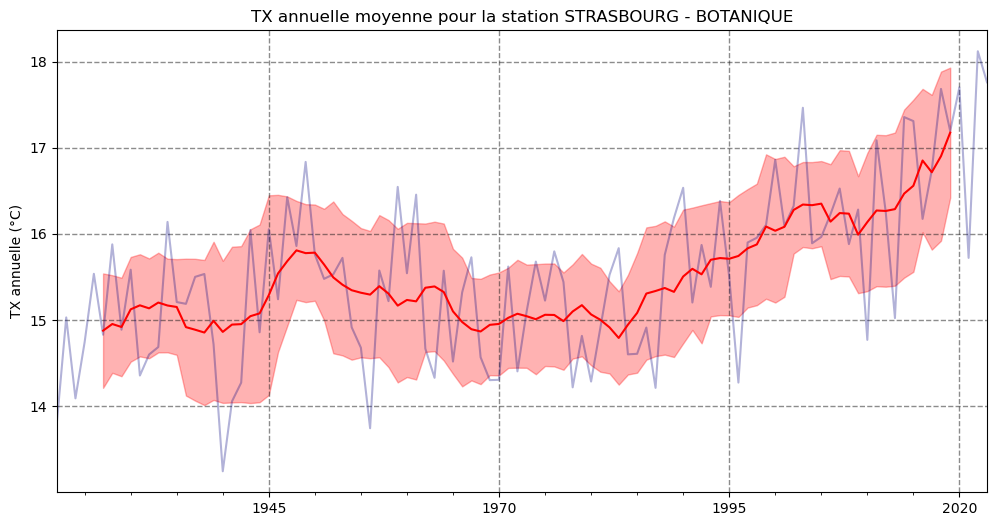

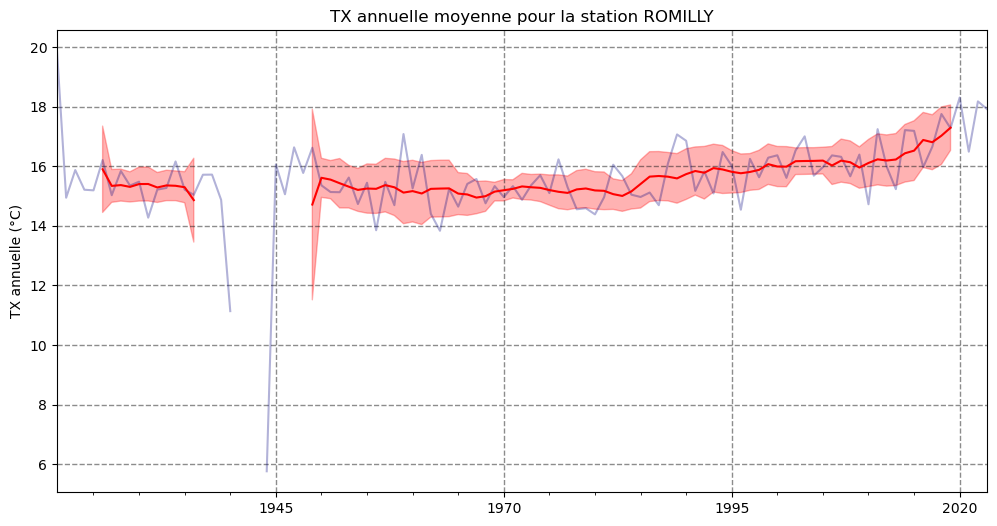

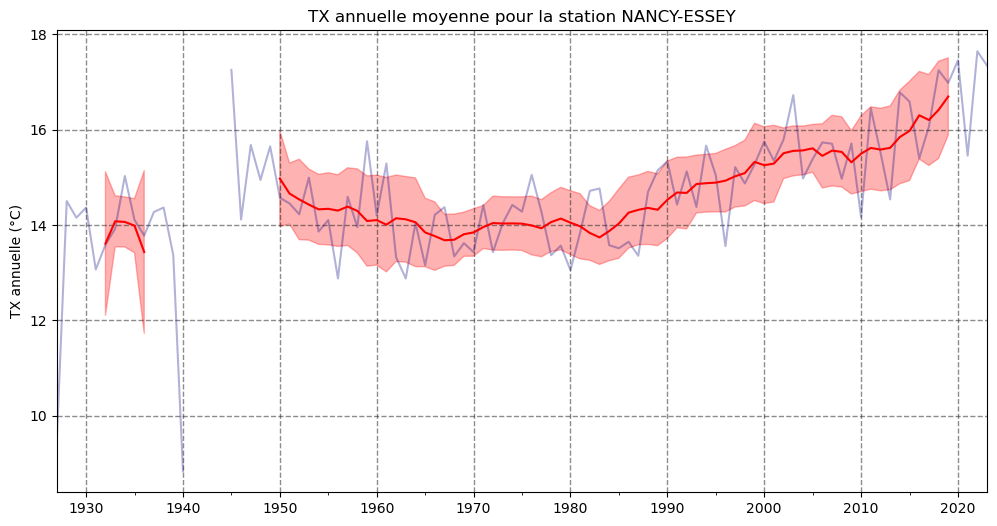

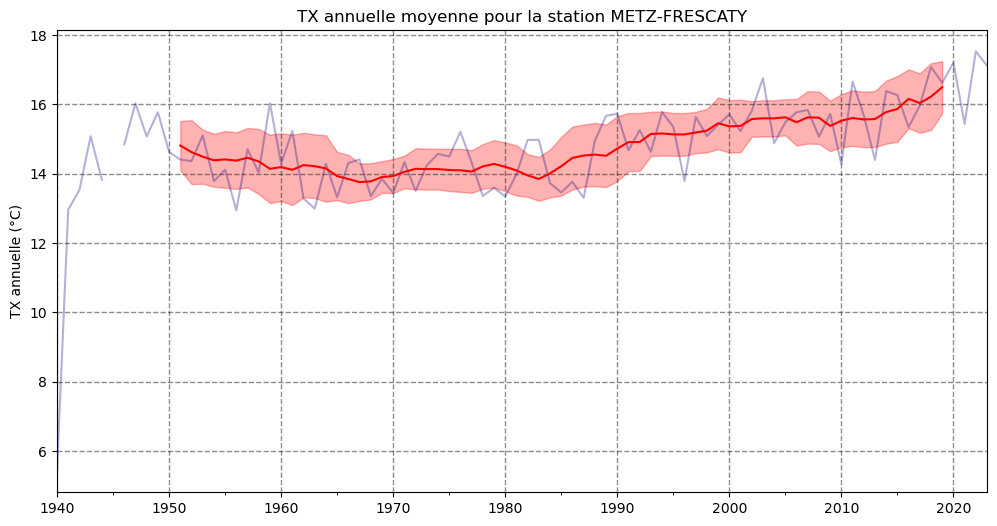

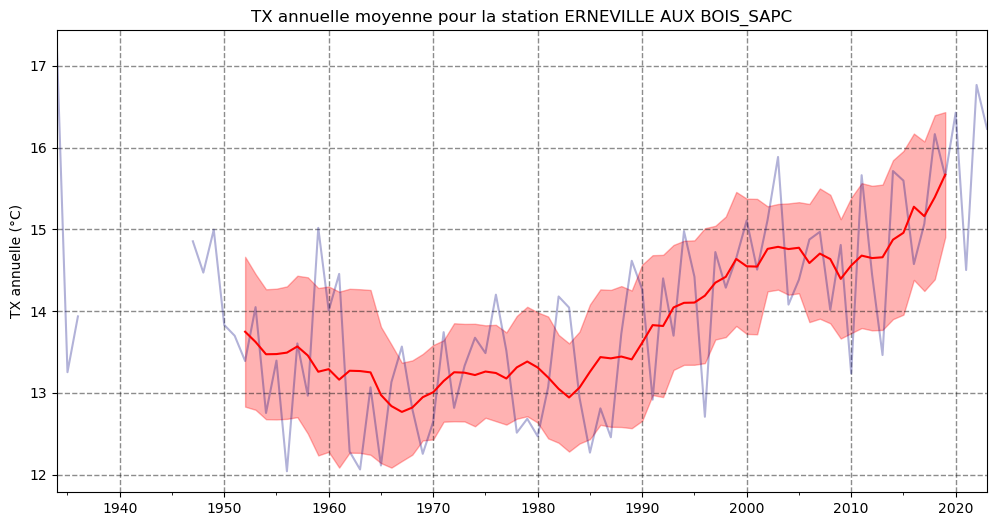

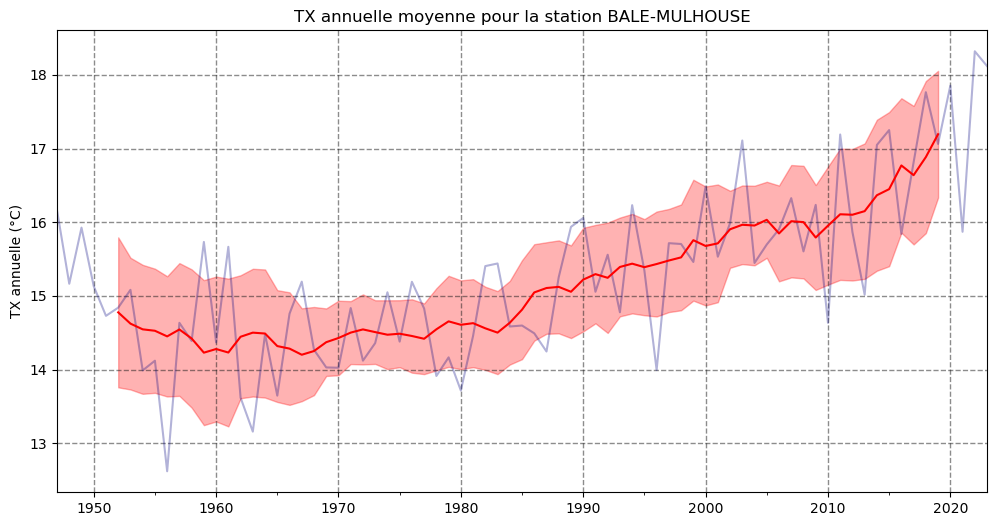

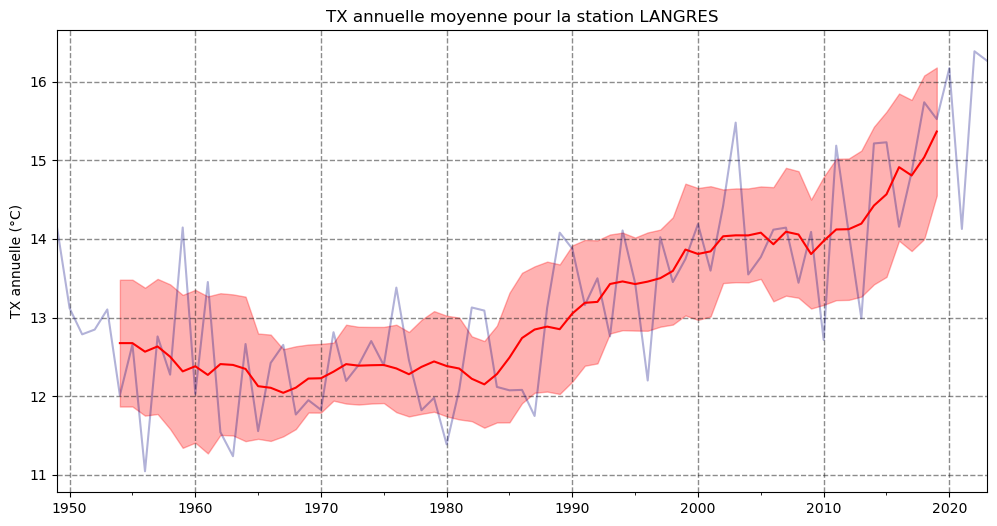

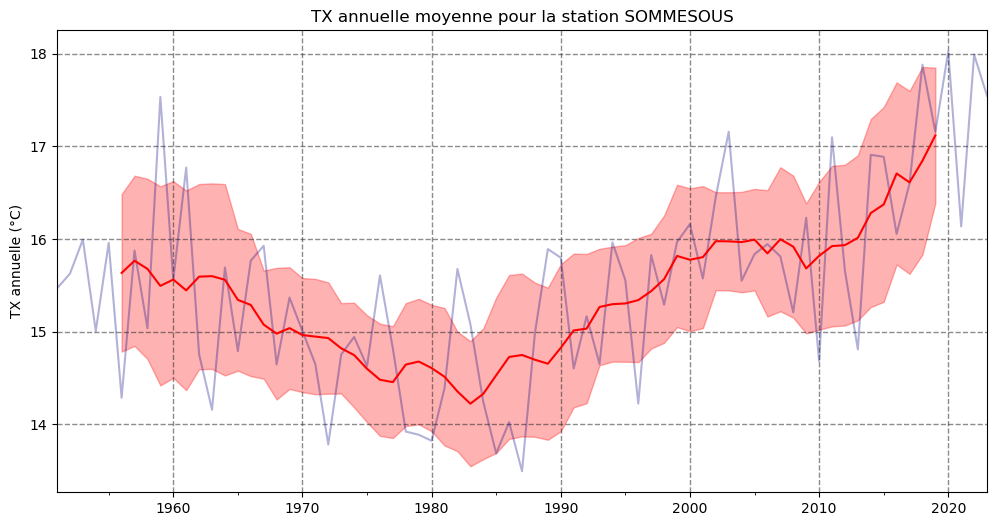

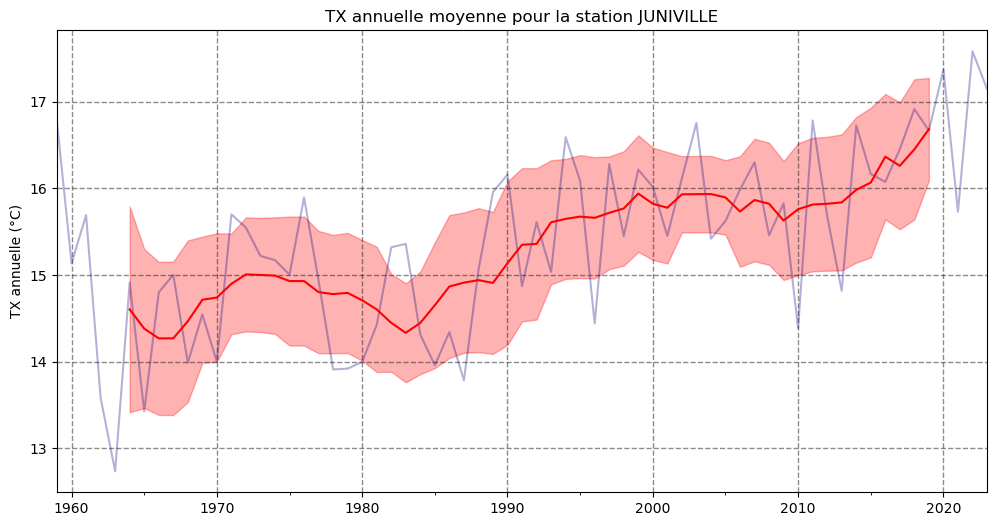

In [141]:
for station in stations_utiles:
    
    df1 = df_temp_maxi[df_temp_maxi['NUM_POSTE'] == station].copy()
    nom_station = list(df1['NOM_USUEL'].unique())[0]
    df_temp_stat = df1.drop(columns=['NUM_POSTE', 'NOM_USUEL'])

    df_temp_maxi_annual = df_temp_stat.resample("AS").agg(['mean', 'min', 'max'])
    
    m = df_temp_maxi_annual[(param, 'mean')].plot(label='température annuelle', figsize=(14, 6), color='navy', alpha=0.3)
    m = df_temp_maxi_annual[(param, 'mean')].rolling(10, center=True).agg(['mean', 'std'])
    ax = m['mean'].plot(label='moyenne glissante sur 10 ans', figsize=(12, 6), color='red')
    ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.3, color = 'red')
    ax.set_title(param + ' annuelle moyenne pour la station ' + nom_station)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel("")
    plt.ylabel(param + " annuelle (°C)")    
    plt.show()
    

## Plotly Graph

In [38]:
df_temp_maxi_annual = pd.DataFrame()
for station in stations_utiles:    
    df0 = df_temp_maxi[df_temp_maxi['NUM_POSTE'] == station].copy()
    nom_stat = list(df0['NOM_USUEL'].unique())[0]
    df0 = df0.drop(columns=['NUM_POSTE', 'NOM_USUEL'])
    df0 = df0.resample("AS").agg(['mean', 'min', 'max'])
    df0['NUM_POSTE'] = station
    df0['NOM_USUEL'] = nom_stat
    df_temp_maxi_annual = pd.concat([df_temp_maxi_annual, df0])

df_temp_maxi_annual

TX            NUM_POSTE               NOM_USUEL
                 mean  min   max                                  
AAAAMMJJ                                                          
1922-01-01  13.829589 -7.5  33.1  67482001  STRASBOURG - BOTANIQUE
1923-01-01  15.029863 -8.1  35.7  67482001  STRASBOURG - BOTANIQUE
1924-01-01  14.090437 -3.4  34.5  67482001  STRASBOURG - BOTANIQUE
1925-01-01  14.744658 -8.5  36.2  67482001  STRASBOURG - BOTANIQUE
1926-01-01  15.536164 -5.0  33.0  67482001  STRASBOURG - BOTANIQUE
...               ...  ...   ...       ...                     ...
2019-01-01  16.665479 -0.1  41.3   8239001               JUNIVILLE
2020-01-01  17.370492  1.7  37.8   8239001               JUNIVILLE
2021-01-01  15.730137 -1.0  31.2   8239001               JUNIVILLE
2022-01-01  17.580548 -0.9  39.5   8239001               JUNIVILLE
2023-01-01  17.145205  1.3  34.1   8239001               JUNIVILLE

[766 rows x 5 columns]

In [ ]:
df_temp_maxi_annual.columns = [' '.join(col).strip() for col in df_temp_maxi_annual.columns.values]


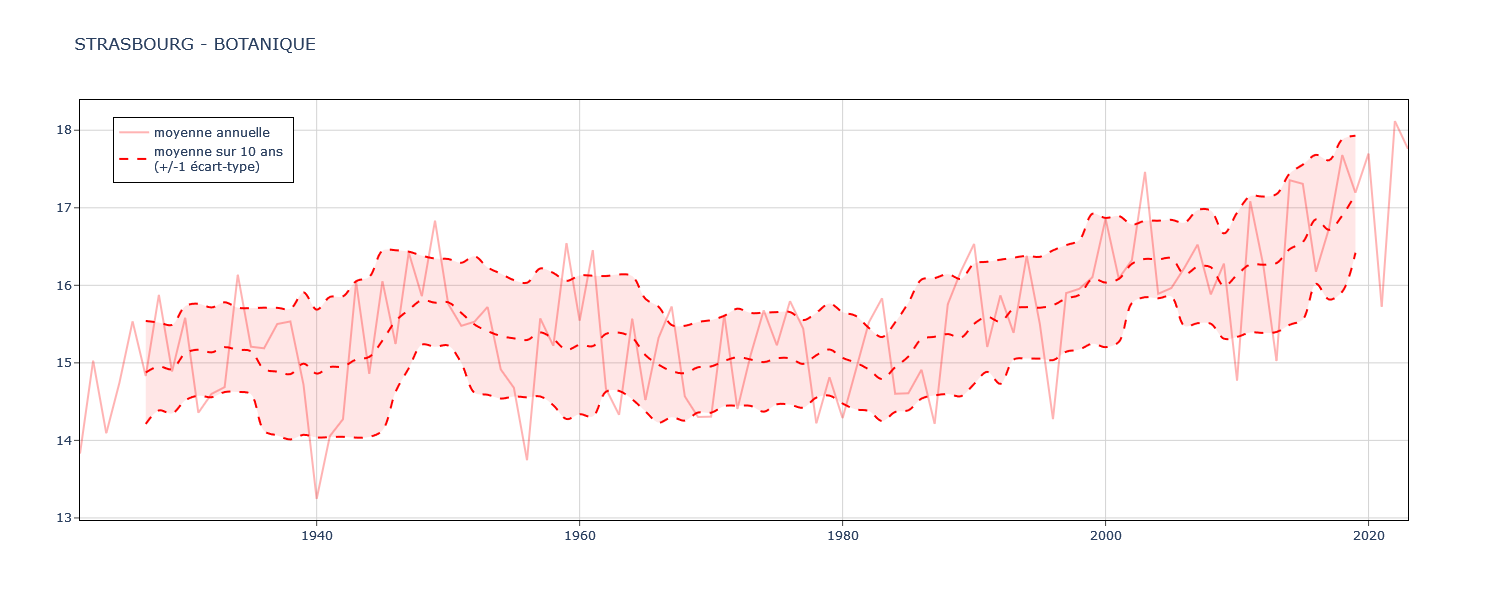

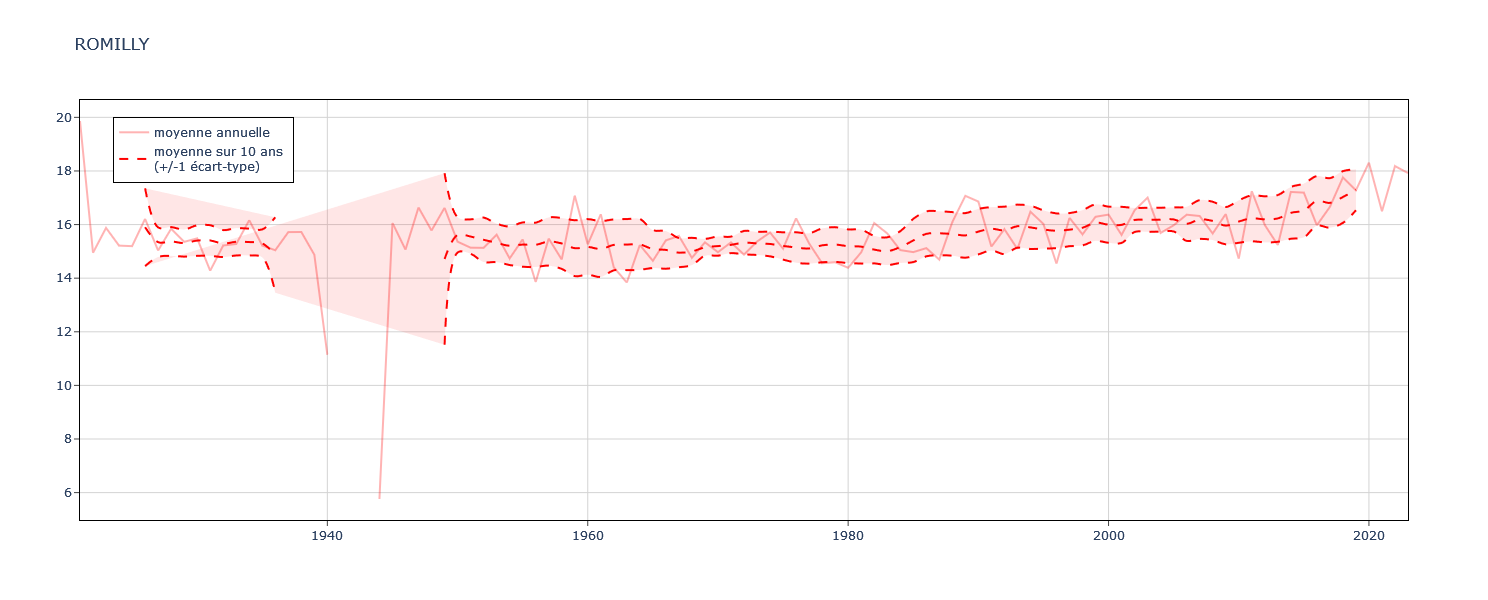

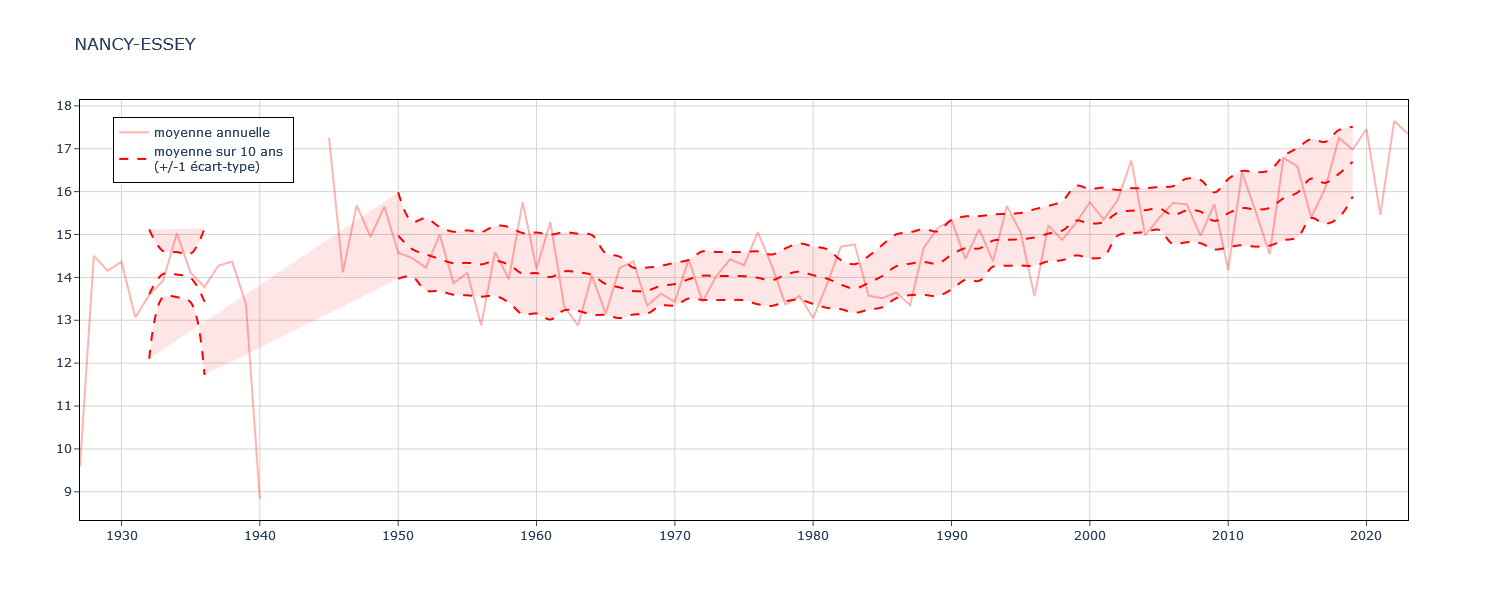

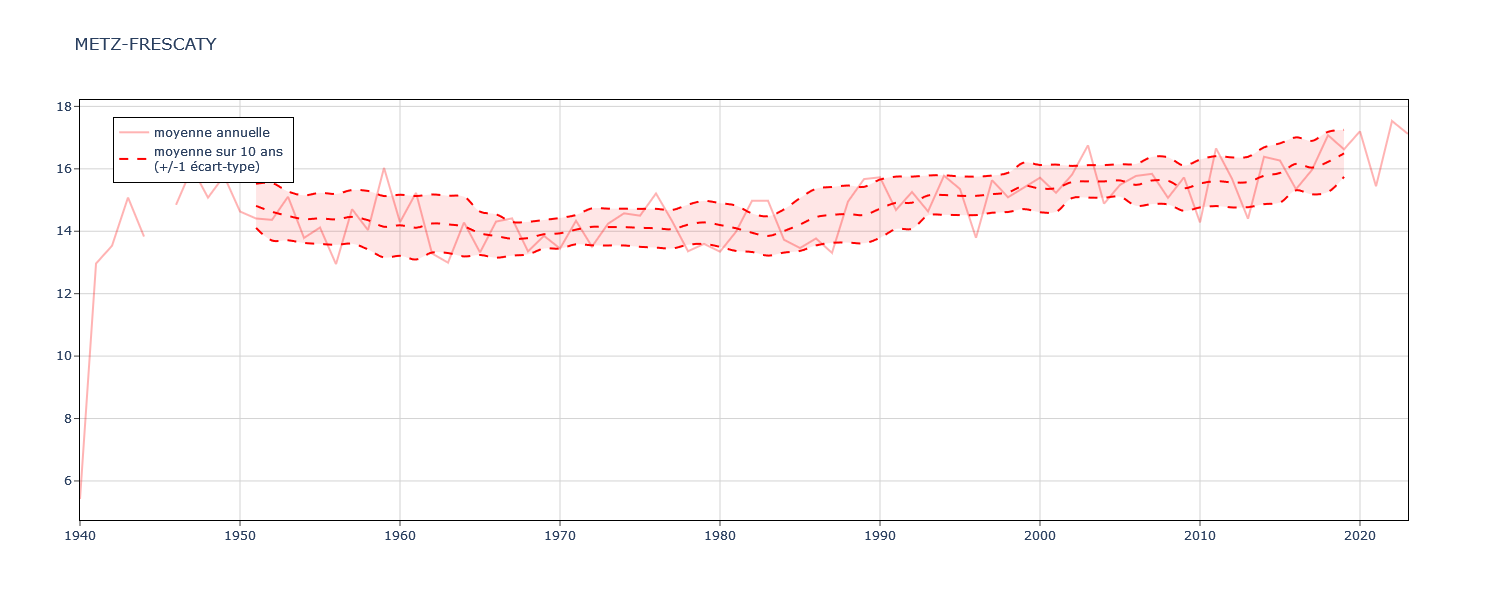

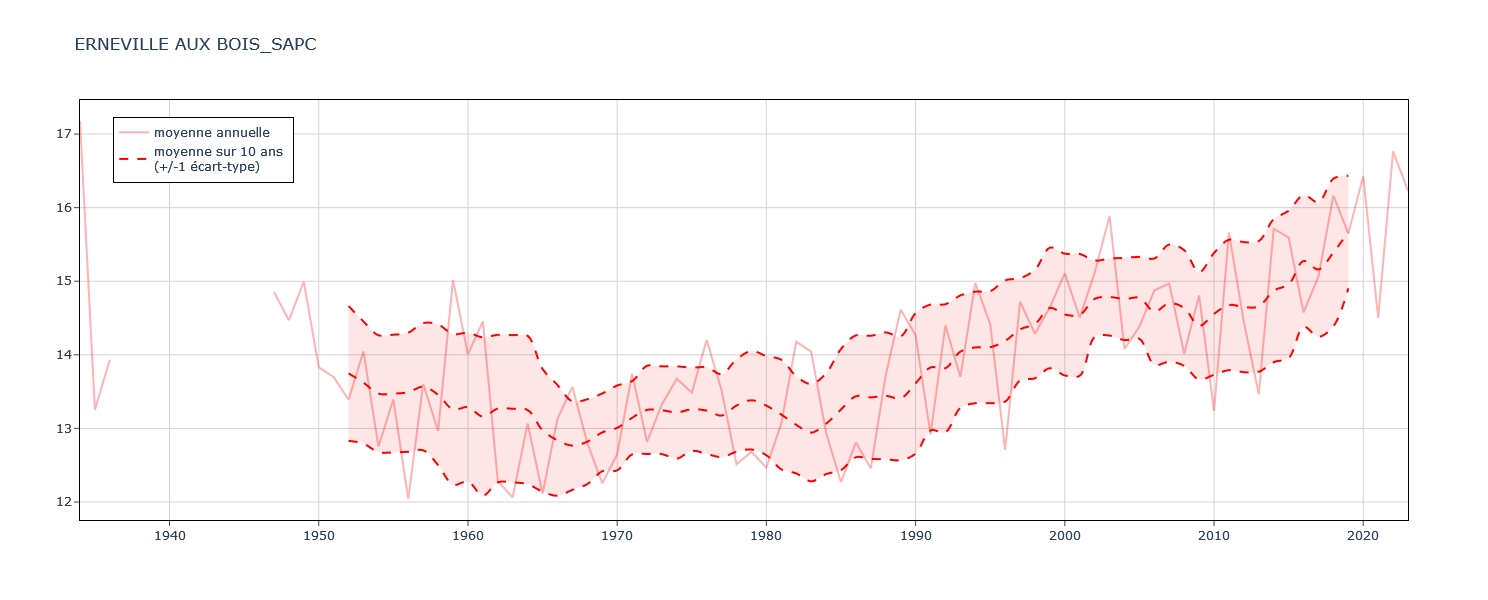

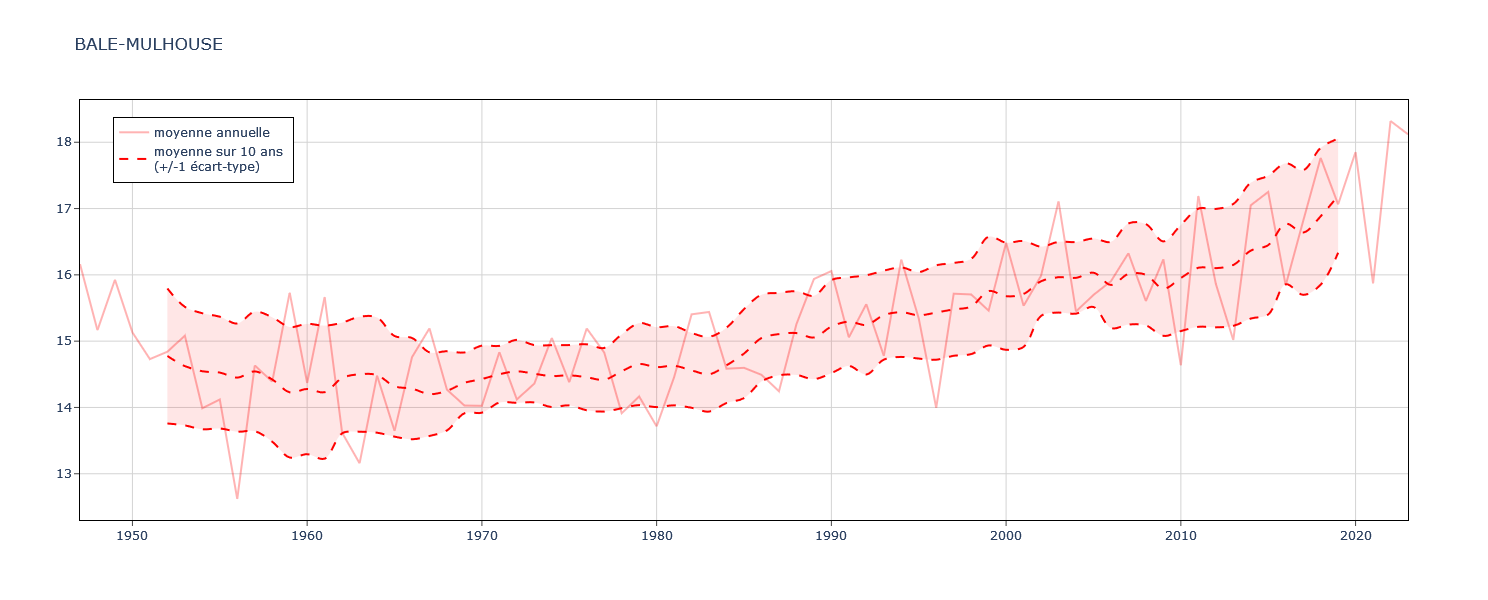

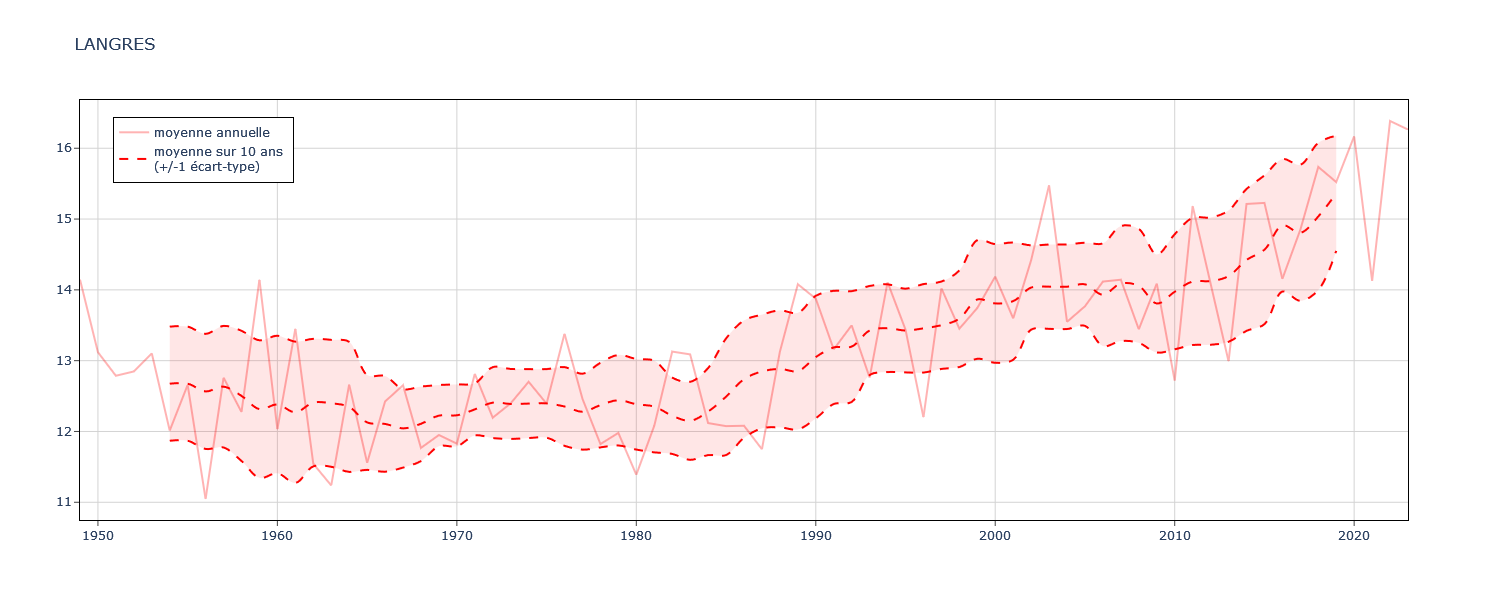

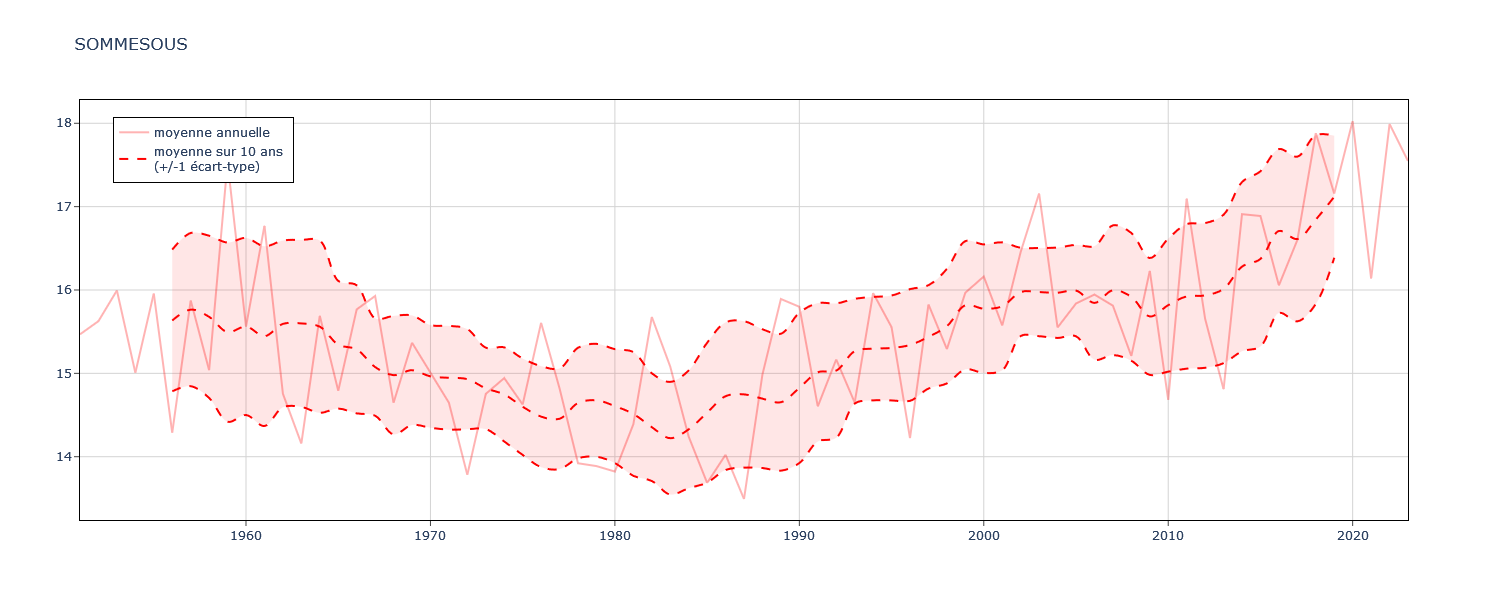

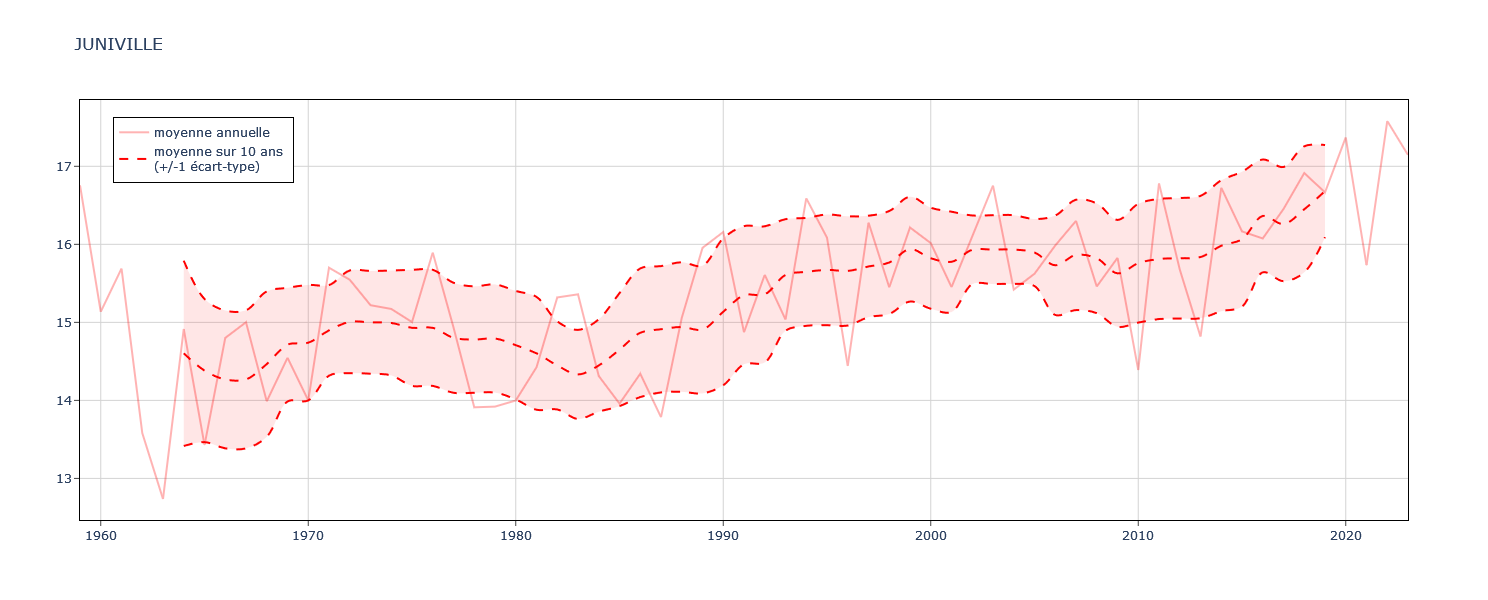

"\n m = df_temp_maxi_annual[(param, 'mean')].plot(label='yearly temperature', figsize=(14, 6))\n    m = df_temp_maxi_annual[(param, 'mean')].rolling(5, center=True).agg(['mean', 'std'])\n    ax = m['mean'].plot(label='5 years rolling window mean', figsize=(12, 6))\n    ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)\n    ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)\n    plt.autoscale(enable=True, axis='x', tight=True)\n\nfig.update_layout(height=600)\nfig.show()\n"

In [69]:

#color_station = ['green', 'red', 'blue', 'firebrick', 'yellow', 'purple', 'orange', 'navy', 'black']
for i, station in enumerate(stations_utiles):
    fig = go.Figure()
    dfi = df_temp_maxi_annual[df_temp_maxi_annual['NUM_POSTE'] == station]
    m = dfi[param + ' mean'].rolling(10, center=True).agg(['mean', 'std'])
    upper = m['mean'] + m['std']
    lower = (m['mean'] - m['std'])    
    
    fig.add_trace(go.Scatter(x=m.index,
                             y=m["mean"],
                             mode='lines',
                             name = 'moyenne sur 10 ans<br>(+/-1 écart-type)',
                             line=dict(color='red', width=2, dash = 'dash', shape='spline'),                             
                             ))
    fig.add_trace(go.Scatter(x=dfi.index,
                             y=dfi[param + " mean"],
                             mode='lines',
                             name = 'moyenne annuelle',
                             line=dict(color='red', width=2),
                             opacity = 0.3))
    fig.add_trace(go.Scatter(x=m.index,
                             y=upper,                             
                             line=dict(color='red', width=2, dash = 'dash', shape='spline'),
                             showlegend=False,                            
                            ))
    fig.add_trace(go.Scatter(x=m.index,
                             y=lower,                             
                             line=dict(color='red', width=2, dash = 'dash', shape='spline'),
                             showlegend = False,
                             fill = 'tonexty',
                             fillcolor = 'rgba(255, 0, 0, 0.1)',
                            opacity = 0.3))
    fig.update_layout(height=600,plot_bgcolor='white',
                      legend=dict(x=0.025,y=0.96, font=dict(size=12,),bordercolor='black',borderwidth=1),
                     title = list(dfi['NOM_USUEL'].unique())[0])
    fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey')
    
    fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    fig.show()



## Station Particulière avec TN, TM et TX

In [5]:
params = ['TN', 'TM', 'TX']
station_code = 8105005 # CHARLEVILLE-MEZ
station_name = 'CHARLEVILLE-MEZ'


In [6]:
df_station1 = df_all[df_all['NUM_POSTE'] == station_code]

In [7]:
df_station_params = df_station1.copy()
for p in params:
    df_station_params = df_station_params[~(df_station1[p].isna())]


C:\Users\thepe\AppData\Local\Temp\ipykernel_12608\113104081.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_station_params = df_station_params[~(df_station1[p].isna())]


In [8]:
df_station_params

NUM_POSTE        NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  \
574627     8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  19900101  0.0   
574628     8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  19900102  0.0   
574629     8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  19900103  0.0   
574630     8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  19900104  0.0   
574631     8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  19900105  0.0   
...            ...              ...        ...       ...   ...       ...  ...   
1206110    8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  20240110  0.0   
1206111    8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  20240111  0.0   
1206112    8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  20240112  0.0   
1206113    8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  20240113  0.0   
1206114    8105005  CHARLEVILLE-MEZ  49.782833  4.643167   145  20240114  0.0   

         QRR   TN  QTN  ...  DXI2  QDXI2  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  \
574627   1.0 -2.0  1.0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN   
574628   1.0 -2.2  1.0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN   
574629   1.0  0.2  1.0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN   
574630   1.0 -1.6  1.0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN   
574631   1.0 -0.2  1.0  ...   NaN    NaN   NaN    NaN    NaN     NaN    NaN   
...      ...  ...  ...  ...   ...    ...   ...    ...    ...     ...    ...   
1206110  1.0 -6.1  1.0  ...   NaN    NaN   NaN    NaN    6.7     1.0    NaN   
1206111  1.0 -7.2  1.0  ...   NaN    NaN   NaN    NaN    5.7     1.0    NaN   
1206112  1.0 -3.9  1.0  ...   NaN    NaN   NaN    NaN    6.6     1.0    NaN   
1206113  1.0 -1.7  1.0  ...   NaN    NaN   NaN    NaN    5.3     1.0    NaN   
1206114  1.0 -4.6  1.0  ...   NaN    NaN   NaN    NaN    5.7     1.0    NaN   

         QDXI3S   HXI3S  QHXI3S  
574627      NaN     NaN     NaN  
574628      NaN     NaN     NaN  
574629      NaN     NaN     NaN  
574630      NaN     NaN     NaN  
574631      NaN     NaN     NaN  
...         ...     ...     ...  
1206110     NaN  1112.0     9.0  
1206111     NaN  1535.0     9.0  
1206112     NaN   315.0     9.0  
1206113     NaN  1245.0     9.0  
1206114     NaN   956.0     9.0  

[12397 rows x 56 columns]

In [9]:
df_ok = []
for p in params:
    df_ok += [df_tempe2(df_station_params, p)]


In [10]:
for i, df1 in enumerate(df_ok):
    df_ok[i] = df1[df1['AAAAMMJJ'].apply(lambda x:x.year) < datetime.date.today().year]
    df_ok[i].set_index("AAAAMMJJ", inplace=True)


In [11]:

for i, df1 in enumerate(df_ok):
        nom_stat = list(df1['NOM_USUEL'].unique())[0]
        df1 = df1.drop(columns=['NUM_POSTE', 'NOM_USUEL'])
        df1 = df1.resample("AS").agg(['mean', 'min', 'max'])
        df1['NUM_POSTE'] = station_code
        df1['NOM_USUEL'] = station_name
        
        df1.columns = [' '.join(col).strip() for col in df1.columns.values]
        df_ok[i] = df1.copy()
   

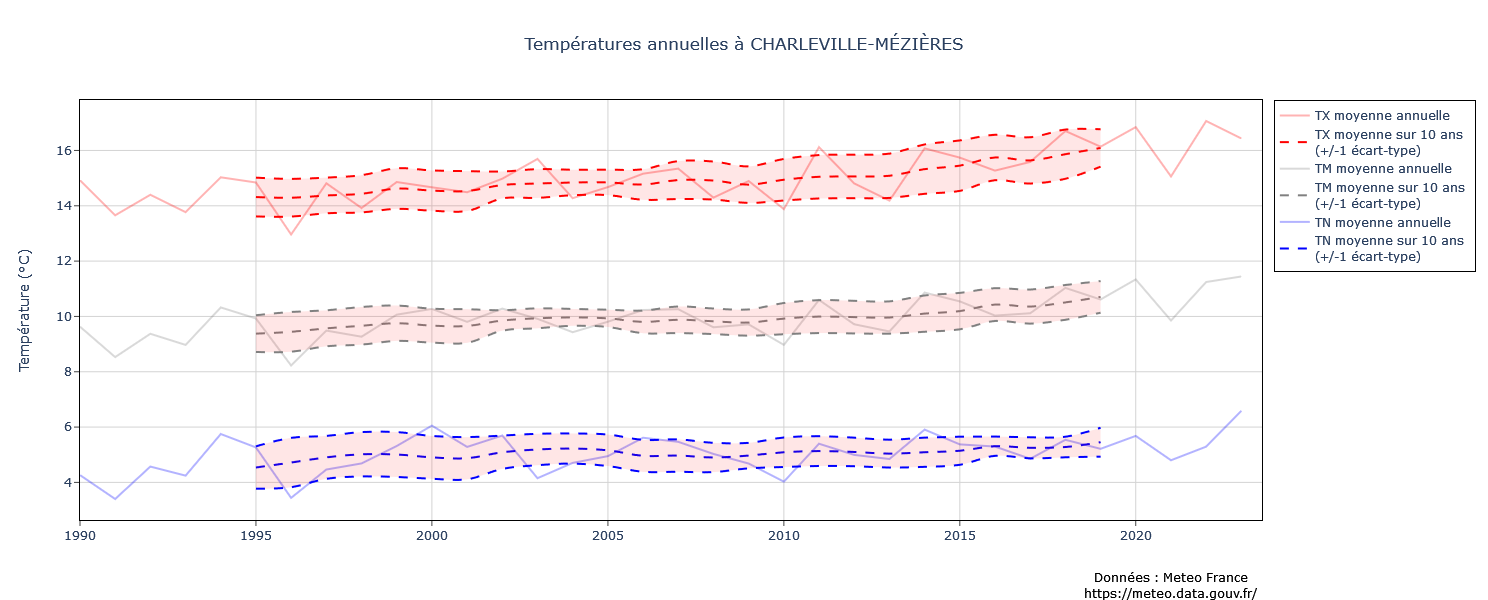

In [12]:
nom_station = 'CHARLEVILLE-MÉZIÈRES'

fig = go.Figure()
colors = ['blue', 'grey', 'red']

for color, param, df1 in zip(colors, params, df_ok):
    m = df1[param + ' mean'].rolling(10, center=True).agg(['mean', 'std'])
    upper = m['mean'] + m['std']
    lower = (m['mean'] - m['std'])    
    
    fig.add_trace(go.Scatter(x=m.index,
                             y=m["mean"],
                             mode='lines',
                             name = param + ' moyenne sur 10 ans<br>(+/-1 écart-type)',
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne sur 10 ans= ' + '%{y:.1f}<extra></extra>',
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),                             
                             ))
    fig.add_trace(go.Scatter(x=df1.index,
                             y=df1[param + " mean"],
                             mode='lines',
                             name = param + ' moyenne annuelle',                                                         
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne = ' + '%{y:.1f}<extra></extra>',
                             line=dict(color=color, width=2),
                             opacity = 0.3))
    fig.add_trace(go.Scatter(x=m.index,
                             y=upper,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend=False,
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy +1 écart-type = ' + '%{y:.1f}',
                            ))
    fig.add_trace(go.Scatter(x=m.index,
                             y=lower,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend = False,
                             fill = 'tonexty',
                             fillcolor = 'rgba(255, 0, 0, 0.1)',
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy -1 écart-type = ' + '%{y:.1f}',
                             opacity = 0.3))

fig.update_layout(height=600,plot_bgcolor='white',
                      legend=dict(x=1.01,y=1, font=dict(size=12,),bordercolor='black',borderwidth=1),
                     title = dict(text= 'Températures annuelles à ' + nom_station, x=0.5))
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey')
    
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title = 'Température (°C)'
    )
fig.add_annotation(
    x="2021", y=-0.2, # position
    yref='paper',
    text="Données : Meteo France<br>https://meteo.data.gouv.fr/", # text
    font = dict(color = 'black'),
    showarrow=False    
   )

    
fig.show()

### Graph avec annotations

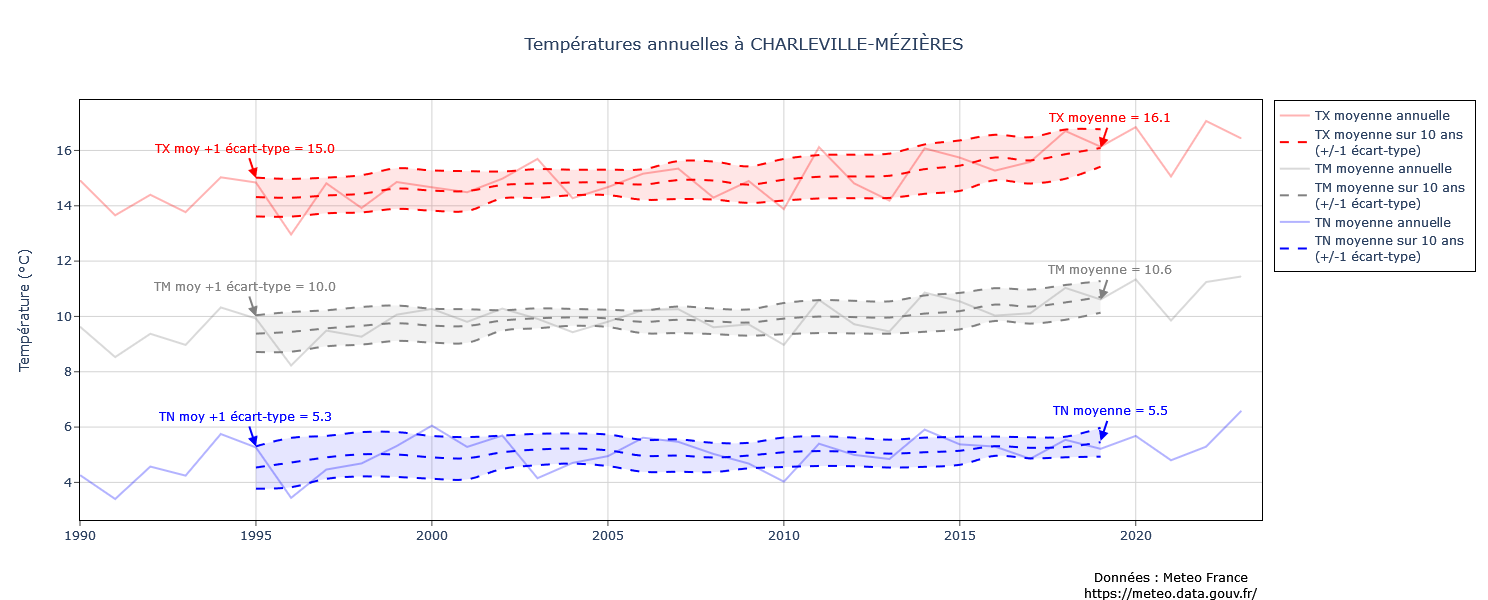

In [13]:
fig2 = go.Figure()
colors = ['blue', 'grey', 'red']
colors_t = ['rgba(0, 0, 255, 0.1)', 'rgba(125, 125, 125, 0.1)', 'rgba(255, 0, 0, 0.1)']

for color, color_t, param, df1 in zip(colors, colors_t, params, df_ok):
    m = df1[param + ' mean'].rolling(10, center=True).agg(['mean', 'std'])
    upper = m['mean'] + m['std']
    lower = (m['mean'] - m['std'])    
    
    fig2.add_trace(go.Scatter(x=m.index,
                             y=m["mean"],
                             mode='lines',
                             name = param + ' moyenne sur 10 ans<br>(+/-1 écart-type)',
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne sur 10 ans= ' + '%{y:.1f}<extra></extra>',
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),                             
                             ))
    fig2.add_trace(go.Scatter(x=df1.index,
                             y=df1[param + " mean"],
                             mode='lines',
                             name = param + ' moyenne annuelle',                                                         
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne = ' + '%{y:.1f}<extra></extra>',
                             line=dict(color=color, width=2),
                             opacity = 0.3))
    fig2.add_trace(go.Scatter(x=m.index,
                             y=upper,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend=False,
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy +1 écart-type = ' + '%{y:.1f}',
                            ))
    fig2.add_trace(go.Scatter(x=m.index,
                             y=lower,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend = False,
                             fill = 'tonexty',
                             fillcolor = color_t,
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy -1 écart-type = ' + '%{y:.1f}',
                             opacity = 0.3))

fig2.update_layout(height=600,plot_bgcolor='white',
                      legend=dict(x=1.01,y=1, font=dict(size=12,),bordercolor='black',borderwidth=1),
                     title = dict(text= 'Températures annuelles à ' + nom_station, x=0.5))
fig2.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey')
    
fig2.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title = 'Température (°C)'
    )


    

fig2.add_annotation(
    x="1995", y=5.3, # position
    text="TN moy +1 écart-type = 5.3", # text
    font = dict(color = 'blue'),
    
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="blue"
)
fig2.add_annotation(
    x="2019", y=5.5, # position
    text="TN moyenne = 5.5", # text
    font = dict(color = 'blue'),
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="blue",
    ax = 10 #positive value for arrow right to left, negative else
    
)

fig2.add_annotation(
    x="1995", y=10.0, # position
    text="TM moy +1 écart-type = 10.0", # text
    font = dict(color = 'grey'),
    
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="grey"
)
fig2.add_annotation(
    x="2019", y=10.6, # position
    text="TM moyenne = 10.6", # text
    font = dict(color = 'grey'),
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="grey",
    ax = 10 #positive value for arrow right to left, negative else
    
)

fig2.add_annotation(
    x="1995", y=15.0, # position
    text="TX moy +1 écart-type = 15.0", # text
    font = dict(color = 'red'),
    
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="red"
)
fig2.add_annotation(
    x="2019", y=16.1, # position
    text="TX moyenne = 16.1", # text
    font = dict(color = 'red'),
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="red",
    ax = 10 #positive value for arrow right to left, negative else
    )
fig2.add_annotation(
    x="2021", y=-0.2, # position
    yref='paper',
    text="Données : Meteo France<br>https://meteo.data.gouv.fr/", # text
    font = dict(color = 'black'),
    showarrow=False    
   )

fig2.show()

**Lors de la dernière décennie, les températures moyennes (TN, TM et TX) étaient supérieures aux températures moyennes +1 écart-type de la décennie des années 1990**

## Station Particulière avec RR

In [212]:
param = 'RR'
station_code = 8105005 # CHARLEVILLE-MEZ
station_name = 'CHARLEVILLE-MEZ'

In [173]:
df_station2 = df_all[df_all['NUM_POSTE'] == station_code]
# df_station2 = df_all[df_all['NOM_USUEL'] == station_name]

In [174]:
df_station_param2 = df_tempe2(df_station2, param)
df_station_param2 = df_station_param2[df_station_param2['AAAAMMJJ'].apply(lambda x:x.year) < datetime.date.today().year]
df_station_param2.set_index("AAAAMMJJ", inplace=True)

In [175]:
df_station_param2

NUM_POSTE        NOM_USUEL   RR
AAAAMMJJ                                   
1990-01-01    8105005  CHARLEVILLE-MEZ  0.0
1990-01-02    8105005  CHARLEVILLE-MEZ  0.0
1990-01-03    8105005  CHARLEVILLE-MEZ  0.0
1990-01-04    8105005  CHARLEVILLE-MEZ  0.0
1990-01-05    8105005  CHARLEVILLE-MEZ  0.0
...               ...              ...  ...
2023-12-27    8105005  CHARLEVILLE-MEZ  0.2
2023-12-28    8105005  CHARLEVILLE-MEZ  0.0
2023-12-29    8105005  CHARLEVILLE-MEZ  1.4
2023-12-30    8105005  CHARLEVILLE-MEZ  0.0
2023-12-31    8105005  CHARLEVILLE-MEZ  1.4

[12397 rows x 3 columns]

In [176]:
nom_station = list(df_station_param2['NOM_USUEL'].unique())[0]
df_station_param2 = df_station_param2.drop(columns=['NUM_POSTE', 'NOM_USUEL'])
df_station_param2 = df_station_param2.resample("AS").agg(['sum'])
df_station_param2.columns = [' '.join(col).strip() for col in df_station_param2.columns.values]

In [177]:
df_station_param2

RR sum
AAAAMMJJ          
1990-01-01   845.9
1991-01-01   712.6
1992-01-01   915.3
1993-01-01  1069.8
1994-01-01   907.1
1995-01-01   994.0
1996-01-01   707.0
1997-01-01   840.4
1998-01-01  1026.4
1999-01-01  1170.8
2000-01-01  1130.2
2001-01-01  1150.0
2002-01-01  1065.6
2003-01-01   778.8
2004-01-01   899.2
2005-01-01   652.2
2006-01-01   948.4
2007-01-01  1148.8
2008-01-01  1053.9
2009-01-01   930.8
2010-01-01   848.9
2011-01-01   795.9
2012-01-01  1138.3
2013-01-01   898.3
2014-01-01   890.3
2015-01-01   828.2
2016-01-01   819.6
2017-01-01   857.1
2018-01-01   861.3
2019-01-01   866.7
2020-01-01   907.9
2021-01-01   977.2
2022-01-01   698.8
2023-01-01  1160.6

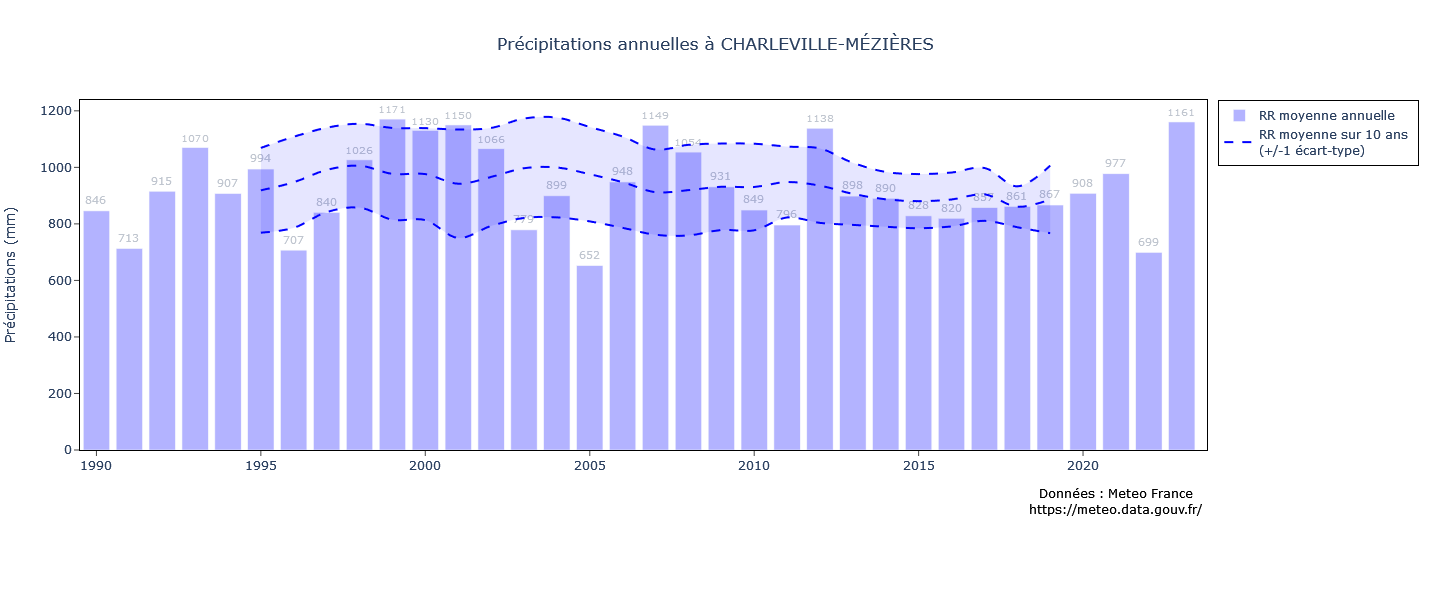

In [213]:
nom_station = 'CHARLEVILLE-MÉZIÈRES'
df3 = df_station_param2.copy()
color = 'blue'

fig3 = go.Figure()



m = df3[param + ' sum'].rolling(10, center=True).agg(['mean', 'std'])
upper = m['mean'] + m['std']
lower = (m['mean'] - m['std'])    
    
fig3.add_trace(go.Scatter(x=m.index,
                             y=m["mean"],
                             mode='lines',
                             name = param + ' moyenne sur 10 ans<br>(+/-1 écart-type)',
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne sur 10 ans= ' + '%{y:.1f}<extra></extra>',
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),                             
                             ))
fig3.add_trace(go.Bar(x=df3.index,
                             y=df3[param + " sum"],
                             #mode='lines',
                             name = param + ' moyenne annuelle',                                                         
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moyenne = ' + '%{y:.1f}<extra></extra>',
                          texttemplate="%{y:.0f}",
                              textposition = 'outside',
                             marker_color='blue',
                             opacity = 0.3))

fig3.add_trace(go.Scatter(x=m.index,
                             y=upper,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend=False,
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy +1 écart-type = ' + '%{y:.1f}',
                            ))
fig3.add_trace(go.Scatter(x=m.index,
                             y=lower,                             
                             line=dict(color=color, width=2, dash = 'dash', shape='spline'),
                             showlegend = False,
                             fill = 'tonexty',
                             fillcolor = 'rgba(0, 0, 255, 0.1)',
                             name = "",                             
                             hovertemplate = 'Année %{x|%Y}<br>' + param + ' moy -1 écart-type = ' + '%{y:.1f}',
                             opacity = 0.3))

fig3.update_layout(height=600,plot_bgcolor='white',margin=dict(b=150),
                      legend=dict(x=1.01,y=1, font=dict(size=12,),bordercolor='black',borderwidth=1),
                     title = dict(text= 'Précipitations annuelles à ' + nom_station, x=0.5))
fig3.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='white',
    )
    
fig3.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='white',
    title = 'Précipitations (mm)'
    )

fig3.add_annotation(
    x="2021", y=-0.2, # position
    yref='paper',
    text="Données : Meteo France<br>https://meteo.data.gouv.fr/", # text
    font = dict(color = 'black'),
    showarrow=False    
   )


    
fig3.show()